In [1]:
import matplotlib.pyplot as plt      
from mpl_toolkits import mplot3d
import os
import sys
import glob
import time
import shutil
import gym
from gym import error, spaces, utils
import numpy as np
import math
from pathlib import Path

In [2]:
import gym_fish
from gym_fish.envs.lib import pyflare as fl

In [3]:
Experiment_name = 'test reward scaling TWO_WAY mass1 4_30 radius 2.0 no random target frame_skip 5'
Experiment_note = "0.5 1000 mass =1 action3 mass1 "

In [4]:
os.chdir(Path(os.getcwd()+"/../").resolve())
print(os.getcwd())

/root/FishEnvPy/rl_test_new


### Import Settings

In [5]:
cwd = os.getcwd()+"/"
data_folder =cwd+ 'py_data/'
json_folder =data_folder+'jsons/'
path_folder =json_folder+'paths/'
scripts_folder = cwd+'scripts/'

In [6]:
fluid_json = json_folder+'fluid_param_0.5.json'
rigid_json = json_folder+'rigids_4_30.json'
path_json = str(Path("./py_data/jsons/paths/line.json").resolve())
print(fluid_json)
print(rigid_json)
print(path_json)

/root/FishEnvPy/rl_test_new/py_data/jsons/fluid_param_0.5.json
/root/FishEnvPy/rl_test_new/py_data/jsons/rigids_4_30.json
/root/FishEnvPy/rl_test_new/py_data/jsons/paths/line.json


In [7]:
def plot_infos(infos,title,reward_fig_name):
    dd = {k:[] for k in infos[0].keys()}
    for info in infos:
        for k in info.keys():
            dd[k].append(info[k])
    plt.figure()
    for k in dd.keys():
        if k=='action_penality':
            plt.plot(np.arange(0,len(dd[k])),[kkk  for kkk in dd[k]],label=k)
        else:
            plt.plot(np.arange(0,len(dd[k])),dd[k],label=k)
    plt.legend()
    plt.title(title)
    plt.savefig(reward_fig_name)
    plt.show()

### Output Settings

In [8]:
store_folder_name = time.strftime('%Y-%m-%d/',time.localtime(time.time()))+Experiment_name+'_'+time.strftime('%Y-%m-%d %H:%M/',time.localtime(time.time()))
imgs_folder_name = 'imgs/'
rl_data_folder_name = 'rl_data/'
rl_data_all_name='collected_o_a.npz'
network_folder_name = 'networks/'
store_folder = cwd+'output_data/'+store_folder_name
imgs_folder = store_folder+imgs_folder_name
rl_data_folder= store_folder+rl_data_folder_name
network_folder = store_folder+network_folder_name

if not os.path.exists(store_folder):
    os.makedirs(store_folder)
if not os.path.exists(imgs_folder):
    os.makedirs(imgs_folder)
if not os.path.exists(rl_data_folder):
    os.makedirs(rl_data_folder)
if not os.path.exists(network_folder):
    os.makedirs(network_folder)

## Saving sources

In [9]:
save_sources = True
sources_folder_name = ['py_data','scripts']
if save_sources==True:
    for fn in sources_folder_name:
        shutil.copytree(cwd+fn,store_folder+'sources/'+fn)
with open(store_folder+'note.txt','w+') as f:
    f.write(time.strftime('%Y-%m-%d %H:%M\n',time.localtime(time.time())))
    f.write(Experiment_note)

### RL_TRAINING Setup

In [10]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines import PPO2
from stable_baselines.common import make_vec_env
# from stable_baselines.sac.policies import MlpPolicy
# from stable_baselines import SAC
from stable_baselines.common.vec_env import DummyVecEnv, VecCheckNan,VecNormalize

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## RL Begin

In [11]:
algo = 'PPO2'
algofoler=algo+'/'
if not os.path.exists(network_folder+algofoler):
    os.makedirs(network_folder+algofoler)
if not os.path.exists(network_folder+algofoler+'imgs/'):
    os.makedirs(network_folder+algofoler+'imgs/')
if not os.path.exists(network_folder+algofoler+'imgs/trajs/'):
    os.makedirs(network_folder+algofoler+'imgs/trajs/')
if not os.path.exists(network_folder+algofoler+'imgs/rewards/'):
    os.makedirs(network_folder+algofoler+'imgs/rewards/')
if not os.path.exists(network_folder+algofoler+'models/'):
    os.makedirs(network_folder+algofoler+'models/')

In [12]:
from gym_fish.envs import FishEnv
env = make_vec_env(FishEnv, 
                   n_envs=1,
                   env_kwargs={
                       'gpuId':0,
                       'path_json':path_json,
                       'couple_mode':fl.COUPLE_MODE.TWO_WAY,"frame_skip":5,"radius":2.0,"theta":np.array([0,0]),
                       'action_max':3,
                       'fluid_json':fluid_json,"wp":1.0,"wr":0.0,"wa":0.00,"random_vel":np.array([0,0]),
                       'rigid_json':rigid_json,
                       
                   })
# env = VecNormalize(env, norm_obs=False, norm_reward=False)
env_test=gym.make('fish-v0', 
                  gpuId=0,
                       path_json=path_json,
                        couple_mode= fl.COUPLE_MODE.TWO_WAY,frame_skip=5,radius=2.0,
                  theta=np.array([0,0]),action_max=3,
                  random_vel=np.array([0,0]),
                       fluid_json=fluid_json,wp=1.0,wr=0.0,wa=0.00,
                       rigid_json=rigid_json,
                   )


In [13]:

policy_kwargs = None
model = PPO2(MlpPolicy, 
             env, n_steps=2048,
             verbose=1,
             tensorboard_log=network_folder+algofoler,
            )





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





In [14]:
def evaluate_env(env_test,model,title,traj_fig_name,reward_fig_name,save=False,eval_trajs=1,render=False):
    
    obs = env_test.reset()
    dones = False
    infos = []
    reward = 0
    while not dones:
        action, _states = model.predict(obs, deterministic=True)
        if not save:
            obs, r, dones,info=env_test.step(action)
        else:
            obs, r, dones,info=env_test.stepSave(action,save_fluid=True)
        if render:
            env_test.render()
        reward=reward+r
        infos.append(info)
    plot_infos(infos,title=title,reward_fig_name=reward_fig_name)
    env_test.plot3d(title=title,fig_name = traj_fig_name)
    
    rewards= [reward]
    for i in range(eval_trajs-1):
        obs = env_test.reset()
        dones = False
        reward=0
        while not dones:
            action, _states = model.predict(obs, deterministic=True)
            obs, r, dones,_=env_test.step(action)
            reward=reward+r
        rewards.append(reward)
    print(np.mean(rewards))
    return np.mean(rewards)

### RL Train

In [15]:
timesteps = int(1e6*20)
step = int(1e3*20)
length =int(timesteps/step) 
print(timesteps,step,length)
last_best_reward = -1e5
cur_steps = 0

20000000 20000 1000




--------------------------------------
| approxkl           | 0.00022669145 |
| clipfrac           | 0.0           |
| ep_len_mean        | 1e+03         |
| ep_reward_mean     | -304          |
| explained_variance | 0.0206        |
| fps                | 8             |
| n_updates          | 1             |
| policy_entropy     | 5.677186      |
| policy_loss        | -0.0002814974 |
| serial_timesteps   | 2048          |
| time_elapsed       | 2.86e-05      |
| total_timesteps    | 2048          |
| value_loss         | 18.474215     |
--------------------------------------
--------------------------------------
| approxkl           | 4.9944654e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 1e+03         |
| ep_reward_mean     | -312          |
| explained_variance | 0.0413        |
| fps                | 8             |
| n_updates          | 2             |
| policy_entropy     | 5.6792545     |
| policy_loss        | 0.00019911886 |
| serial_timesteps   | 

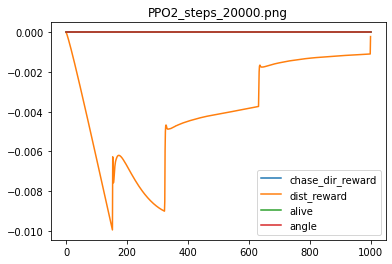

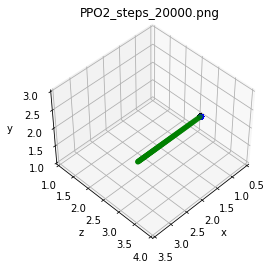

-3.850259645536653
---------------------------------------
| approxkl           | 0.00047915638  |
| clipfrac           | 0.0            |
| ep_len_mean        | 1e+03          |
| ep_reward_mean     | -295           |
| explained_variance | 0.0479         |
| fps                | 8              |
| n_updates          | 1              |
| policy_entropy     | 5.6963468      |
| policy_loss        | -0.00082044455 |
| serial_timesteps   | 2048           |
| time_elapsed       | 3.96e-05       |
| total_timesteps    | 20480          |
| value_loss         | 17.32306       |
---------------------------------------
-------------------------------------
| approxkl           | 0.0010129943 |
| clipfrac           | 0.002319336  |
| ep_len_mean        | 1e+03        |
| ep_reward_mean     | -294         |
| explained_variance | 0.0831       |
| fps                | 8            |
| n_updates          | 2            |
| policy_entropy     | 5.7001157    |
| policy_loss        | -0.002850024 |
|

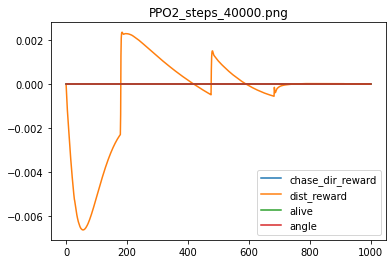

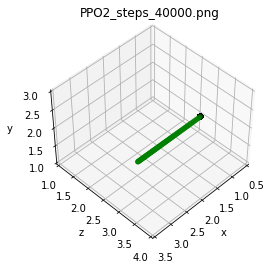

-0.47572799471959115
--------------------------------------
| approxkl           | 0.00036810187 |
| clipfrac           | 0.0           |
| ep_len_mean        | 1e+03         |
| ep_reward_mean     | -282          |
| explained_variance | 0.0539        |
| fps                | 8             |
| n_updates          | 1             |
| policy_entropy     | 5.7171392     |
| policy_loss        | -0.0003485968 |
| serial_timesteps   | 2048          |
| time_elapsed       | 4.53e-05      |
| total_timesteps    | 38912         |
| value_loss         | 15.236157     |
--------------------------------------
---------------------------------------
| approxkl           | 0.00021668209  |
| clipfrac           | 0.0            |
| ep_len_mean        | 1e+03          |
| ep_reward_mean     | -284           |
| explained_variance | 0.0735         |
| fps                | 8              |
| n_updates          | 2              |
| policy_entropy     | 5.719594       |
| policy_loss        | -0.00049131

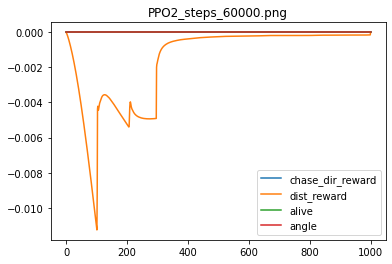

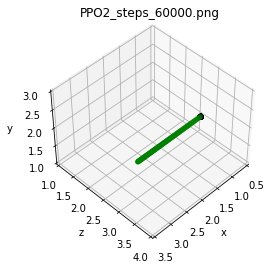

-1.5644556646201409
--------------------------------------
| approxkl           | 0.0007657431  |
| clipfrac           | 0.00024414062 |
| ep_len_mean        | 1e+03         |
| ep_reward_mean     | -290          |
| explained_variance | 0.0811        |
| fps                | 8             |
| n_updates          | 1             |
| policy_entropy     | 5.7288737     |
| policy_loss        | 0.0006959444  |
| serial_timesteps   | 2048          |
| time_elapsed       | 3.15e-05      |
| total_timesteps    | 57344         |
| value_loss         | 15.154755     |
--------------------------------------
---------------------------------------
| approxkl           | 8.209133e-05   |
| clipfrac           | 0.0            |
| ep_len_mean        | 1e+03          |
| ep_reward_mean     | -289           |
| explained_variance | 0.0511         |
| fps                | 8              |
| n_updates          | 2              |
| policy_entropy     | 5.7297583      |
| policy_loss        | -0.000323822

In [ ]:
while cur_steps<timesteps:
    model.learn(total_timesteps=step, log_interval=1, reset_num_timesteps=False)
    cur_steps = cur_steps+step
    img_name =algo+ "_steps_{0}.png".format(cur_steps)
    model.save(network_folder+algofoler+'models/'+"_steps_{0}".format(cur_steps))
    rr = evaluate_env(env_test,model,title=img_name,traj_fig_name=network_folder+algofoler+'imgs/trajs/'+img_name,reward_fig_name=network_folder+algofoler+'imgs/rewards/'+img_name)
    if rr>last_best_reward:
        last_best_reward=rr
        model.save(network_folder+algofoler+'models/best')

In [17]:
!./clean_visdata.sh

rm: cannot remove './data/vis_data/Objects/*': No such file or directory
rm: cannot remove './data/vis_data/Fluid/*': No such file or directory


In [ ]:
# model =  PPO2.load('/root/FishEnvPy/rl_test_new/output_data/2021-01-28/test local coordinate TWO_WAY mass1 4_30 radius 2.0 no random target frame_skip 5_2021-01-28 14:07/networks/PPO2/models/_steps_320000.zip')

In [ ]:
# fluid_json = json_folder+'fluid_param_1.0.json'

# env_test=gym.make('fish-v0', 
#                   gpuId=0,
#                        path_json=path_json,
#                         couple_mode= fl.COUPLE_MODE.TWO_WAY,frame_skip=10,radius=2.0,
#                   theta=np.array([0,0]),
#                   random_vel=np.array([0,0]),
#                        fluid_json=fluid_json,wp=1.0,wr=0.0,wa=0.00,
#                        rigid_json=rigid_json,
#                    )
# # env_test.rigid_data.rigidWorld.setTimestep(0.001)
# print(env_test.rigid_data.rigidWorld.getTimestep())

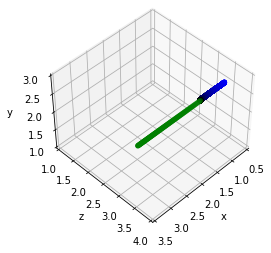

In [19]:
obs = env_test.reset()
dones = False
infos = []
reward = 0
while not dones:
    action, _states = model.predict(obs, deterministic=False)
    obs, r, dones,info=env_test.stepSave(action,save_objects=False,save_fluid=False)
    reward=reward+r
    infos.append(info)
env_test.plot3d()

In [ ]:
plot_infos(infos,title="title",reward_fig_name="reward_fig_name")
dynamics = env_test.rigid_data.skeletons[0].dynamics        
x_axis = dynamics.getBaseLinkFwd()
y_axis = dynamics.getBaseLinkUp()
z_axis = dynamics.getBaseLinkRight()
print(x_axis,y_axis,z_axis,dynamics.getBaseLink().getPosition())

## Evaluation and Test

In [ ]:
# from matplotlib.patches import FancyArrowPatch
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d.proj3d import proj_transform
# from mpl_toolkits.mplot3d.axes3d import Axes3D
# class Arrow3D(FancyArrowPatch):
#     def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
#         super().__init__((0,0), (0,0), *args, **kwargs)
#         self._xyz = (x,y,z)
#         self._dxdydz = (dx,dy,dz)

#     def draw(self, renderer):
#         x1,y1,z1 = self._xyz
#         dx,dy,dz = self._dxdydz
#         x2,y2,z2 = (x1+dx,y1+dy,z1+dz)

#         xs, ys, zs = proj_transform((x1,x2),(y1,y2),(z1,z2), renderer.M)
#         self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
#         super().draw(renderer)
# def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
#     '''Add an 3d arrow to an `Axes3D` instance.'''
#     arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
#     ax.add_artist(arrow)
# setattr(Axes3D,'arrow3D',_arrow3D)

In [ ]:
# %matplotlib notebook

In [ ]:
# ### test generalization to sequence goals
# init_pos=np.array([1,2,3])
# radius = 0.5
# theta = 0/180*math.pi
# goal_dir=np.array([1,0,0])
# # plt.close(fig)
# # fig = plt.figure()
# # ax = fig.add_subplot(111, projection='3d')
# goal_positions = [init_pos]
# goal_dirs = []
# init_positions=[]
# for i in range(20):
#     theta = np.random.uniform(-40/180*math.pi, 40/180*math.pi)
#     rot_mat = np.array([[math.cos(theta),0,-math.sin(theta)],[0,1,0],[math.sin(theta),0,math.cos(theta)]])
# #     ax.arrow3D(init_pos[0],init_pos[2],init_pos[1],goal_dir[0],goal_dir[2],goal_dir[1],arrowstyle="-|>",)
#     goal_pos = init_pos+radius*goal_dir
#     init_positions.append(init_pos)
#     goal_dirs.append(goal_dir)
#     goal_positions.append(goal_pos)
#     init_pos = goal_pos
#     goal_dir = np.dot(rot_mat,goal_dir)
    
# traj  =  fl.make_trajectory()
# path_points = []
# for p in goal_positions:
#     pp =  fl.make_tpPoint()
#     pp.data = p
#     path_points.append(pp)
# traj.setPoints(path_points)
# traj.fit()
# traj.sample(100)
# paths_by_t= np.array([ traj.getPose(t).getPosition()  for t in np.arange(0.0,1.0,1.0/100) ])

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# X = paths_by_t[:,0]
# Y = paths_by_t[:,1]
# Z = paths_by_t[:,2]
# ax.scatter3D(xs=X, zs=Y, ys=Z,c=[[0,i/len(paths_by_t),0] for i in range(paths_by_t.shape[0])])
# ax.set_xlabel('x')
# ax.set_ylabel('z')
# ax.set_zlabel('y')
# max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0
# mid_x = (X.max()+X.min()) * 0.5
# mid_y = (Y.max()+Y.min()) * 0.5
# mid_z = (Z.max()+Z.min()) * 0.5
# ax.set_xlim(mid_x - max_range, mid_x + max_range)
# ax.set_ylim(mid_z - max_range, mid_z + max_range)
# ax.set_zlim(mid_y - max_range, mid_y + max_range)
# plt.show()

In [ ]:
# !./clean_visdata.sh
# plt.close(fig)
# env_test.reset()
# dones = False
# infos = []
# reward = 0
# env_test.init_pos = init_positions[0]
# env_test.goal_dir =  goal_dirs[0]
# env_test.goal_pos = goal_positions[0]
# t = 0 
# while not dones:
#     obs = env_test._get_obs()
#     if env_test.rigid_data.rigidWorld.time>20 or traj.getReferencePose(env_test.body_xyz) >0.98:
#         print("Time exceed! ",t,env_test.rigid_data.rigidWorld.time)
#         break
#     action,_ = model.predict(obs, deterministic=True)
# #     _, r, _,info=env_test.step(action)
# #     env_test.step(action)
#     env_test.stepSave(action,save_objects=True,save_fluid=False)
# #     if env_test._alive<0:
# #         dones=True
# #         print("Die ")
#     t = traj.getReferencePose(env_test.body_xyz)+0.1
#     env_test.goal_pos = traj.getPose(t).getPosition()
#     env_test.path_dir = traj.getPose(t).getOrientation()
# #     reward=reward+r
# #     infos.append(info)


In [ ]:
# plt.close(fig)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# # ax.scatter3D(xs=X, zs=Y, ys=Z,c=[[0,i/len(paths_by_t),0] for i in range(paths_by_t.shape[0])])
# ax.scatter3D(xs=[x[0] for x in env_test.trajectory_points],
#                 zs=[x[1] for x in env_test.trajectory_points],
#                 ys=[x[2] for x in env_test.trajectory_points],
#                 c=[[i/len(env_test.trajectory_points),0,0] for i in range(len(env_test.trajectory_points))])
# ax.set_xlabel('x')
# ax.set_ylabel('z')
# ax.set_zlabel('y')
# ax.set_xlim(mid_x - max_range, mid_x + max_range)
# ax.set_ylim(mid_z - max_range, mid_z + max_range)
# ax.set_zlim(mid_y - max_range, mid_y + max_range)
# plt.show()